In [305]:
import string
import pandas as pd
import re
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from sklearn.manifold import MDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import time
import ast
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from rapidfuzz import fuzz, process
from collections import defaultdict






# Scrape of Edmounds

In [306]:
# Making the get request from Edmounds

def extract_words_from_url(base_url):
    try:
        # Create a session object to persist settings across 
        
        session = requests.Session()
        
        #initialize a user agent
        ua = UserAgent()
        
        #chrome user agent
        headers = {'User-Agent': ua.chrome}
        
        
 
       #set retry strategy
        retry_strategy = Retry(
            total = 4,
            status_forcelist = [403, 429, 500, 502, 503, 504]
        )
        
        adapter = HTTPAdapter(max_retries=retry_strategy)
        
        session.mount('http://', adapter)   
        session.mount('https://', adapter)
        
      
        #set empty lists for messages, dates and user ids to be added
        all_messages = []
        all_dates = []
        all_user_ids = []
        
        #first page number, to be added to
        page_num = 1
        
        #set maximum length
        while len(all_messages) <= 5000:
            
            if page_num == 1:
                url = base_url
            else:
                url = f"{base_url}/p{page_num}" #adjust page to next page

            #open session 
            response = session.get(url, headers=headers)

            response.raise_for_status() 
        
            
            if response.status_code == 200:
                print(f"Successful request")
        
        

            #parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.content, 'html.parser')
            
            #find the user cards for usernames and extract
            user_cards = soup.find_all('a', class_='PhotoWrap js-userCard')
            author_names = [user_card.get('aria-label').split(': ')[1].strip('"') for user_card in user_cards]
            
            #find messages in the HTML and extract    
            messages = soup.find_all("div", {'class': "Message userContent"})
            messages = [message.get_text().strip() for message in messages]
            
            #find dates and extract
            dates = soup.find_all('time')         
            dates = [date.get_text() for date in dates]
            
            
            #extend the lists for the scraped values
            all_user_ids.extend(author_names)
            all_messages.extend(messages)
            all_dates.extend(dates)
            
            #increase page number
            page_num += 1
            time.sleep(2)  #avoid IP blocking
            
        #take only the first 5000
        final_user_ids = all_user_ids[1:5001]
        final_messages = all_messages[1:5001]
        final_dates = all_dates[1:5001]
        
        scraped_df = pd.DataFrame({
            'Date': final_dates,
            'User-ID': final_user_ids,
            'Message': final_messages    
        })
        
        return scraped_df
            
    except RequestException as e:
        print(f"Error scraping {url}: {e}")  #log the error message
        return [""] * 5  #return a list of 5 empty strings if an error occurs

    finally:
        time.sleep(2) 
    
    scraped_df.to_csv('scraped_data.csv')
    return scraped_df
        
        


scraped_df = extract_words_from_url('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans') #call scrape




Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful request
Successful r

# Top 10 Brands by Frequency and lift

## Replace models with brands

In [307]:

scraped_df_1 = scraped_df.copy()
#scraped_df = pd.read_csv('scraped_data.csv')
car_df = pd.read_csv('Car Models.csv', names = ['brand', 'model']) #read in the car models

#enumerate over all the models and ensure they are lowercase
for idx, car in enumerate(car_df['model']):
    car_df.at[idx, 'model'] = car_df['model'][idx].lower()

#create a dict out of the car names
car_dict = car_df.to_dict(orient = 'records')

#iterate through messages and preprocess the data
for idx, message in enumerate(scraped_df_1['Message']):
    message = str(message)
    processed_message = message.lower().strip()           
    cleaned_message = re.sub(r',(?=\S)|\.(?=\S)', ' ', processed_message)  #replace comma/period without space after it
    processed_message = re.sub(r'[^\w\s-]', '', cleaned_message) #replace normal punctuation
    processed_message = processed_message.split()
    scraped_df_1.at[idx, 'Message'] = processed_message


#use nltk stopwords
stop_words = set(stopwords.words('english')) 

for idx, message in enumerate(scraped_df_1['Message']):
    filtered_words = []
    for word in message:
        if word not in stop_words:
            filtered_words.append(word) #filter for words that are not in stop_words
    scraped_df_1.at[idx, 'Message'] = filtered_words #replace message in scraped_df
    
    
#save a copy of dataframe for later  use
scraped_df_copy = scraped_df_1.copy()

threshold = 95 #set threshold for fuzzy matching

for idx, message in enumerate(scraped_df_1['Message']):
    for i, word in enumerate(message):
        for row in car_dict:
            match = process.extractOne(word, [row['model']], scorer=fuzz.ratio) #fuzzy match for the model
            if match and match[1] >= threshold:
                message[i] = row['brand'] #replace the word in the message with the brand

                
    scraped_df_1.at[idx, 'Message'] = message #replace the message with the correct brand adjusted message
    

scraped_df_1.to_csv('scraped_data_transformed.csv')    #write to csv

    
        
        

## Calcuating top 10 brands by frequency

In [308]:

comment_df = scraped_df_1.copy() 
#comment_df = pd.read_csv('scraped_data_transformed.csv')
#comment_df['Message'] = comment_df['Message'].apply(ast.literal_eval)
brand_df =  pd.DataFrame(car_df['brand'].unique(), columns=['unique_brand']) #get only unique brands


for idx, messages in enumerate(comment_df['Message']):
    unique_messages = list(dict.fromkeys(messages)) #pull a unique set of words from the messages
    unique_car = [] #initialize a unique car list
    for word in unique_messages:
        if word in brand_df['unique_brand'].values:
            unique_car.append(word) #if the unique word is a brand add it to the unique car list
            
    comment_df.at[idx, 'Message'] = unique_car #replace the message with just unique cars
    
    
all_words = sum(comment_df['Message'], []) #combined into a single list
word_counts = Counter(all_words) #count the words


model_count_df = pd.DataFrame([word_counts]) #dataframe for the model count
model_count_df = model_count_df.melt(var_name = 'Model', value_name = 'Count').sort_values('Count', ascending = False).reset_index(drop = True) #melt to have model be the variable and the count be the value associated

# Display the DataFrame as a table
display(model_count_df[:10]) #top 10



,Model,Count
0,bmw,1381
1,acura,538
2,honda,420
3,audi,401
4,infiniti,375
5,toyota,304
6,nissan,295
7,mercedes,210
8,subaru,207
9,volkswagen,178


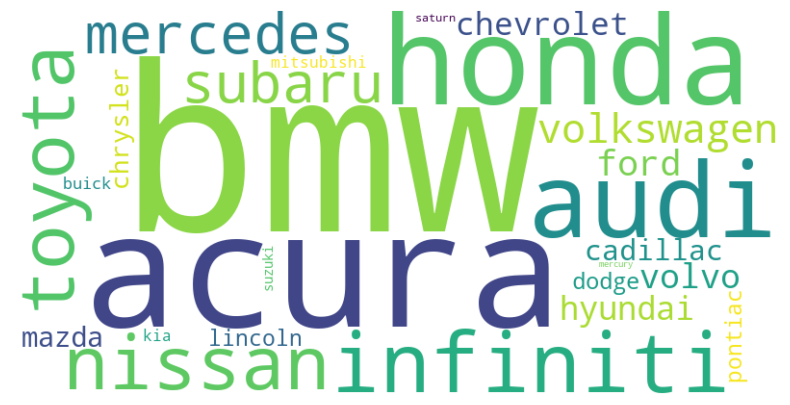

In [309]:

#create a dictionary of words and their frequencies for the word cloud
word_freq_dict = dict(zip(model_count_df['Model'], model_count_df['Count']))

#generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

#plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  #no axes for the word cloud
plt.show()



## Lift Ratios for top 10 brands

Lift Matrix (brand-related terms):



,bmw,acura,honda,audi,infiniti,toyota,nissan,mercedes,subaru,volkswagen
bmw,NaN,1.460,1.250,1.652,1.941,1.405,1.227,1.741,1.189,1.546
acura,1.460,NaN,2.633,2.063,2.999,1.804,2.205,1.903,2.110,1.671
honda,1.250,2.633,NaN,1.484,1.397,3.916,3.914,1.587,1.668,2.274
audi,1.652,2.063,1.484,NaN,2.494,1.313,1.522,3.563,1.626,4.553
infiniti,1.941,2.999,1.397,2.494,NaN,1.228,2.531,1.968,1.739,1.873
toyota,1.405,1.804,3.916,1.313,1.228,NaN,3.847,2.271,1.351,2.218
nissan,1.227,2.205,3.914,1.522,2.531,3.847,NaN,1.533,1.556,2.666
mercedes,1.741,1.903,1.587,3.563,1.968,2.271,1.533,NaN,1.150,3.612
subaru,1.189,2.110,1.668,1.626,1.739,1.351,1.556,1.150,NaN,2.035
volkswagen,1.546,1.671,2.274,4.553,1.873,2.218,2.666,3.612,2.035,NaN


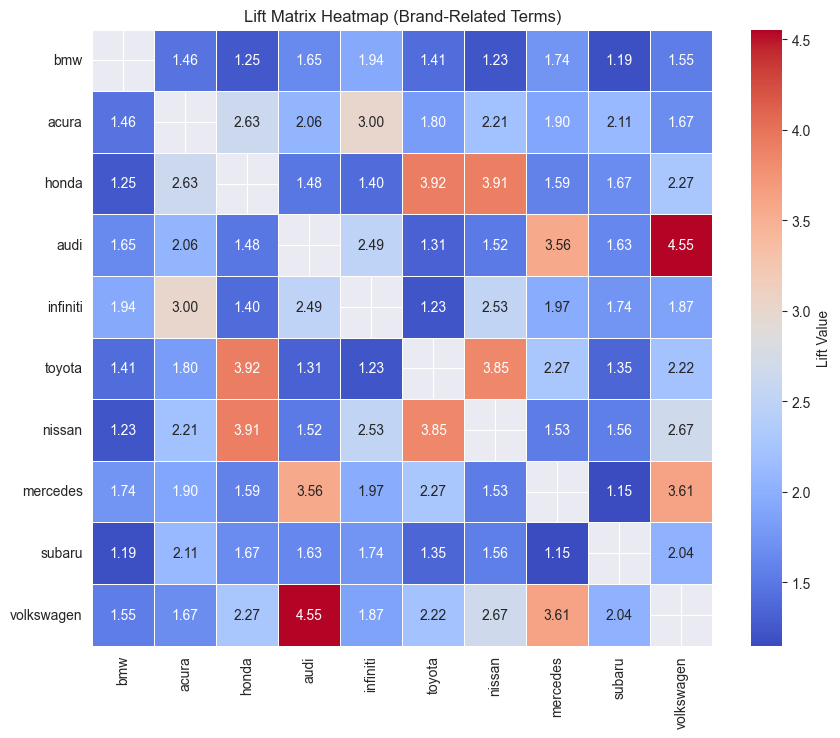

In [310]:
#copy dataset of scraped data
vector_comment_df = scraped_df_1.copy()

#Not needed:
#vector_comment_df = pd.read_csv('scraped_data_transformed.csv')
#vector_comment_df['Message'] = vector_comment_df['Message'].apply(ast.literal_eval)

#set brands to be top 10 models by count
brand_terms = model_count_df['Model'][:10]

#join words in reviews together to create a single list per document
processed_reviews = [' '.join(msg) for msg in comment_df['Message']]


#use CountVectorizer to create the term-document matrix for the brands
vectorizer = CountVectorizer(stop_words='english', vocabulary=brand_terms)  # Limiting to brand-related words
X = vectorizer.fit_transform(processed_reviews)

#get the words (brand terms) from the vectorizer
words = vectorizer.get_feature_names_out()

#create a co-occurrence matrix (co-occurrence of brands across reviews)
co_occurrence_matrix = (X.T * X).toarray()

#set diagonal (self-co-occurrence) to zero (no self-association)
np.fill_diagonal(co_occurrence_matrix, 0)

#compute the brand frequencies (number of reviews each brand appears in)
brand_frequencies = X.sum(axis=0).A1

#calculate the expected co-occurrence matrix
expected_co_occurrence_matrix = np.outer(brand_frequencies, brand_frequencies) / X.shape[0]

#calculate the lift matrix
lift_matrix = co_occurrence_matrix / expected_co_occurrence_matrix

#convert the lift matrix to a DataFrame for easier visualization
lift_df = pd.DataFrame(lift_matrix, index=words, columns=words)

#replace 0 values with NaN to avoid clutter
lift_df.replace(0, np.nan, inplace=True)

#format the values to 3 decimal places
lift_df = lift_df.round(3)

#display the lift matrix
print("Lift Matrix (brand-related terms):\n")
display(lift_df)

#visualize the lift matrix using a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size
sns.heatmap(lift_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Lift Value'})
plt.title('Lift Matrix Heatmap (Brand-Related Terms)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

,Dimension 1,Dimension 2,Model
0,-0.126193,-0.017635,bmw
1,-0.044701,-0.145576,acura
2,0.006725,0.032677,honda
3,0.065192,0.004169,audi
4,-0.046051,0.015501,infiniti
5,0.119096,0.043725,toyota
6,0.049649,0.036710,nissan
7,0.022454,0.061512,mercedes
8,-0.236168,-0.154150,subaru
9,0.189997,0.123067,volkswagen


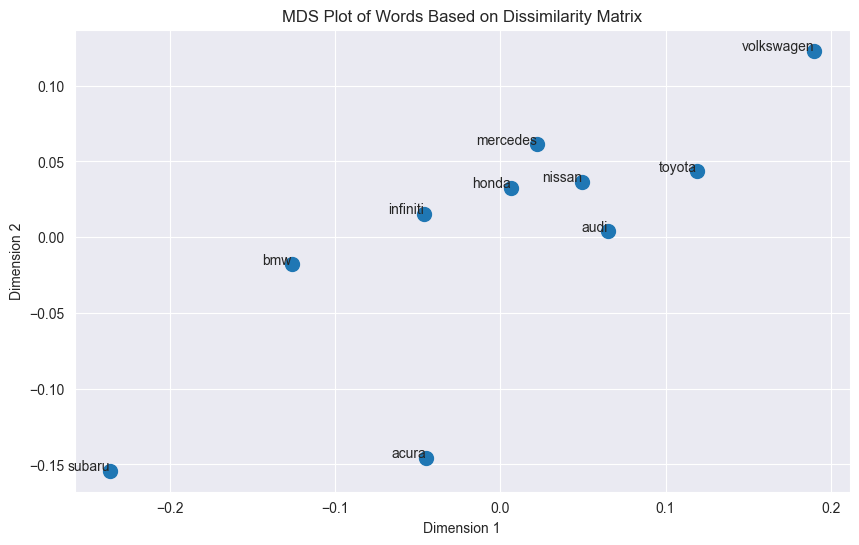

In [311]:

#replace zero or NaN values in the lift matrix to avoid division by zero
lift_df = lift_df.replace([np.inf, -np.inf, 0], np.nan)
lift_df_filled = lift_df.fillna(0)


#calculate the dissimilarity matrix by taking the inverse of the lift values
dissimilarity_matrix = np.linalg.inv(lift_df_filled.values)
dissimilarity_matrix = pd.DataFrame(dissimilarity_matrix, columns=lift_df.columns)


#convert dissimilarity matrix DataFrame to NumPy array
dissimilarity_array = dissimilarity_matrix.to_numpy()

#apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(dissimilarity_array)

#create a DataFrame for the MDS results
mds_df = pd.DataFrame(mds_coordinates, columns=['Dimension 1', 'Dimension 2'], index=dissimilarity_matrix.index)

#join model on the MDS results 
joined_df = mds_df.join(model_count_df[:10]['Model'], how='outer')
display(joined_df)

#plot the MDS result
plt.figure(figsize=(10, 6))
plt.scatter(joined_df['Dimension 1'], joined_df['Dimension 2'], s=100)

#annotate each point with the word
for idx, (x, y, model) in joined_df.iterrows():
    plt.text(x, y, model, fontsize=10, ha='right')

plt.title('MDS Plot of Words Based on Dissimilarity Matrix')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


# Task 3: Executive Summary

Understanding the relationships between your firm and your direct competitors is critical. One way of understanding who your competitors are is to look at the biggest players in your industry through an economic lens. Who has the most capital, the most production capacity, the most sales. Another way is to examine your competition through a social lens. Understanding who you're often compared to, and on what grounds that comparison is taking place. This analysis examines those social comparisons and determines, for each of the major car brands, which brands you are most associated with in the eyes of consumers. 

The preceding analysis was performed on a dataset made up of 5000 scraped posts from edmounds.com. It is aimed at luxury sedan vehicles and examines the associations consumers have created through calculation of lift ratios and through a visualization of the dissimilarity matrix. A lift ratio measures the association of two words in any message. It is calculated as follows:

- $Lift (A,B) = \frac{p(A,B)}{p(A) * p(B)}$

This measure examines the real percentage of posts where word A and word B are present over the joint probability of A and B (assuming both are individual). Simply put it is a measure of whether a combination of words appears more often then it should given the likelihood of those words appearing alone. If a lift value is above 1, those words appear more frequently together than they should, indicating an association between the words. If it is at 1 those words have no association, and if it is below one there is a negative association between the words.

While the dissimilarity matrix measures the logarithm of the inverse of the lift values, calculating a dissimilarity matrix that allows us to visualize how closely related words are in a corpus. 

Understanding this lets explore two associations that we can draw significant meaning from. The first association to examine, is the relationship between Audi, Mercedes, and their lack of relationship with BMW. All three of these German manufacturers are fully established and dominate the German car industry. What is so strange about this group of 3 brands is that it challenges assumptions about German car brands. A long understood assumption was that the luxury sedan market in Germany was dominated by the competition between Audi, Mercedes and BMW, three German brands associated with luxury. However, it seems that consumers consider the BMW to be more unique. This presents a challenge to Mercedes and Audi on how to bridge this gap to BMW who, by their lift ratios, is less frequently mentioned in conjunction with brands. This understanding can redefine the relationship these car companies have with their direct competitors. Particularly Mercedes who has long been at odds with BMW. This association indicates that their true direct competitors are Audi, not BMW, and that they may need to reassess their marketing strategy, or vehicle designs.

Another key understanding to be drawn from this is an extension of the original. It regards and acknowledges the unique position held by Subaru, Volkswagen and Acura in the luxury sedan market. Whether this unique position is positive, neutral or negative is still to be determined. The lack of similarity and association with other brands could present an opportunity to carve out a niche within the market. Or it could indicate that these brands need to exit the market as they aren't being compared to brands of equal footing within the industry. These brands should consider whether they are true players, and if they are, attempt to further subsect the industry to find a loyal consumer base.

While the frequency and association of these words can provide good insight, a deeper understanding of the position they hold is required. Understanding the context of mentions, the themes associated with the brands, and how they're compared is critical. It will provide further insight into consumers perceptions of the market, and the luxury sedan manufacturers within it.




# Section 4: Strongly Associated Attributes

### Step 1: Create a dictionary of words based on documents containing the top 5 brands

In [312]:
#choose the top 5 brands:
top_5_brands = model_count_df[:5]['Model'].to_list()

print('The top 5 most mentioned car brands are: ')
for brand in top_5_brands:
    print(f'{brand}')
    
#copy the transformed dataframe from earlier
scraped_df_assoc = scraped_df_copy.copy()

#only messages associated with the top 5 companies:
for idx, message in enumerate(scraped_df_assoc['Message']):
    if all(brand not in message for brand in top_5_brands):
        scraped_df_assoc.drop([idx], inplace=True)

   
#desired tags are adjectives, looking for descriptives for the vehicles
desired_tags = ['JJ', 'JJR', 'JJS']
tagged_words = [nltk.pos_tag(message) for message in scraped_df_assoc['Message']] #get tagged words

#keep only tagged words or brands from the top 5 brands
pos_words_ext = [[word for word, tag in doc if tag in desired_tags or word in top_5_brands] for doc in tagged_words]

#get words out of the messages in the filtered tagged words
pos_words_ext_2 = [word for message in pos_words_ext for word in message]
#count each of the tagged words
word_counts = Counter(pos_words_ext_2)
pos_words_ext_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count']).sort_values('Count', ascending = False)
pos_words_ext_df = pos_words_ext_df.query('Count > 10') #keep only words that have appeared more than 10 times

# Display the DataFrame as a table
pos_words_ext_df.to_csv('adjectives.csv') #write to csv for assignment
    

The top 5 most mentioned car brands are: 
bmw
acura
honda
audi
infiniti


### Step 2: Assign adjectives and replace words in the corpus

In [313]:
#read in assigned adjectives
assigned_adjectives = pd.read_excel('adjectives_assigned.xlsx', sheet_name='adjectives_assigned')
assigned_adjectives = assigned_adjectives.to_dict(orient = 'list')

#copy in the tagged words documents
pos_words_ext_cop = pos_words_ext.copy()

#in each of documents if a word is in the top 5 brands keep that, if it is one of the listed words replace it with its assigned adjective
for doc_idx, document in enumerate(pos_words_ext_cop):
    replaced_document = []
    for word in document:
        if word in top_5_brands:
            replaced_document.append(word)
            
        elif word in assigned_adjectives['Word']:
            idx = assigned_adjectives['Word'].index(word) #find replacement words
            replacement = assigned_adjectives['Assignment'][idx] #replace word
            replaced_document.append(replacement) #write to replaced document
            
        else:
            continue
    
    pos_words_ext_cop[doc_idx] = replaced_document #replcae the document in the corpus with the adjusted document



### Step 3: Count the assigned adjectives to a brand if they are in proximity to the brand mention

In [314]:

window_size = 1 #set a window size
total_adjective_counts = defaultdict(Counter) #set a dictionary for counting adjectives

#iterate through documents in order to count whether the assigned adjective is nearby
for document in pos_words_ext_cop:
    for i, word in enumerate(document):
        if word in top_5_brands:
            start = max(0, i-window_size)
            end = min(len(words), i + window_size)
            nearby_words = document[start:end]
            
            for nearby_word in nearby_words:
                if nearby_word not in top_5_brands:
                    total_adjective_counts[word][nearby_word] += 1 #count if adjective is present
                    
                    
bra_adj_df = pd.DataFrame(total_adjective_counts).T.reset_index().rename(columns={'index': 'Brand'}) #create a dataframe out of the counter

print("The following are tables of brands and the count of the attributes associated with them: \n")
#examine each brand individually to see which attributes are associated the most with each brand
for brand in bra_adj_df['Brand']:
    brand_df = bra_adj_df.loc[bra_adj_df['Brand']==brand].set_index('Brand')
    top_5_attributes = brand_df.apply(lambda x: x.sort_values(ascending=False).head(5), axis=1)
    display(top_5_attributes)
            
            

The following are tables of brands and the count of the attributes associated with them: 



,Exterior Design,Advanced Technology,Engine Performance,Durability,Interior Design
Brand,,,,,
audi,51.0,48.0,35.0,15.0,12.0


,Exterior Design,Engine Performance,Advanced Technology,Interior Design,Affordability
Brand,,,,,
acura,69.0,41.0,33.0,23.0,20.0


,Exterior Design,Advanced Technology,Engine Performance,Affordability,Interior Design
Brand,,,,,
bmw,218.0,172.0,137.0,88.0,50.0


,Exterior Design,Advanced Technology,Engine Performance,Affordability,Interior Design
Brand,,,,,
infiniti,41.0,21.0,20.0,12.0,10.0


,Exterior Design,Advanced Technology,Engine Performance,Affordability,Durability
Brand,,,,,
honda,62.0,36.0,30.0,22.0,13.0


### Step 4: Determine co-occurrences and PMI

In [315]:
#set matrix for PMI calculations
co_occurrence_counts = defaultdict(Counter)
total_word_count = 0
brand_counts = Counter()
adjective_counts = Counter()

#iterate over each of the documents in the corpus and count the number of times each adjective is associated with a brand, count the total number of words, the total number of brand mentions (individual probability), the total number of adjective mentions (individual probability), and the total number of co-occurrences between brand and adjective (joint probability)
for document in pos_words_ext_cop:
    total_word_count += len(document)  #update total word count
    
    for i, word in enumerate(document):
        if word in top_5_brands:
            brand_counts[word] += 1 #brand count
            
            # Get words in proximity window
            start = max(0, i - window_size)
            end = min(len(document), i + window_size)
            nearby_words = document[start:end]
            
            for nearby_word in nearby_words:
                if nearby_word in assigned_adjectives['Assignment']:
                    co_occurrence_counts[word][nearby_word] += 1 #co-occurrence count
                    adjective_counts[nearby_word] += 1 #adjective count

#compute probabilities and PMI
pmi_scores = defaultdict(dict)
for brand, adj_counts in co_occurrence_counts.items():
    for adjective, co_count in adj_counts.items():
        p_brand = brand_counts[brand]/total_word_count #individual probability of brand
        p_adjective = adjective_counts[adjective]/total_word_count #individual probability of adjective
        p_joint = co_count/total_word_count #joint probability

        # Avoid divide by zero errors
        if p_brand > 0 and p_adjective > 0 and p_joint > 0:
            pmi = np.log2(p_joint/(p_brand * p_adjective)) #log of calculation
            pmi_scores[brand][adjective] = pmi

pmi_df = pd.DataFrame(pmi_scores).fillna(0)
print("\nPMI Scores:")
print(pmi_df)


PMI Scores:
                         audi     acura  infiniti       bmw     honda
Advanced Technology  1.108460  0.275184  0.369613  1.010935  0.812599
Durability           1.192148  0.059905 -0.324834  1.024791  1.094227
Interior Design      0.758810  1.392101  0.744328  0.826472  0.310946
Exterior Design      0.659274  1.035337  0.799121  0.831634  1.016548
Engine Performance   0.757454  0.891012  0.603570  0.928865  0.843023
Comfort              0.752383  1.292566  0.000000  1.141974  0.041486
Riding Comfort       0.521770  1.155062  0.770323  0.741436  1.296300
Affordability        0.208612  0.649259  0.457165  1.075977  1.050256
Outdated Technology  0.244236  1.199456  0.229755  1.008223  0.755731
Craftsmanship       -0.399620 -0.029362  1.170861  0.820046  2.004960
Design               0.851919 -0.192861  0.422400  1.071585  1.141021


# Task 5: Executive Summary (for a product manager and marketing manager at Acura)

Acura represents is in a unique position within the luxury sedan market. While it is not conventionally compared to powerhouses like BMW, Mercedes, or lesser known niche options like Infiniti it represents a significant share of the luxury sedan market and provides consumers a comfortable, beautiful vehicle at a reasonable price. 

In a study done on 5000 posts made by users at Edmounds.com, we have tried to understand why Acura is so impactful in the market, attempting to understand, through the eyes of the consumer, what it does well and what it can improve on. Our methodology for understanding this was to narrow in on understanding what attributes users mentioned the most when discussing Acura. Having scraped all 5000 posts, pre-processed, and cleaned them, we narrowed down every word to get the most common 425 adjectives among all 5000 posts. Further summarizing this, the adjectives were analysed and determined to be of use or not, depending on the type of adjective and descriptive power. These 98 adjectives were then assigned to one of 10 categories:

- Advanced Technology
- Outdated Technology
- Durability
- Craftsmanship
- Exterior Design
- Interior Design
- Comfort
- Riding Comfort
- Engine Performance
- Affordability

Counting how often these categories appeared in proximity of a brand informed on which attributes were most relevant on the minds of consumers when discussing a particular brand. Acura's 5 most mentioned attributes were exterior design, advanced technology, engine performance, durability, and interior design. While this is a fair measurement of important attributes, a more relevant measure is point-wise mutual information. This measurement assesses how often (in terms of probability) we have one phrase mentioned with another. It examines the co-occurrence of attributes and brands with consideration to the total number of mentions in each. With this we find that Acura most relevant attributes are interior design, comfort, riding comfort, exterior design and outdated technology. Along the lines of interior design, comfort and riding comfort it significantly outpaces its direct competitors regarding co-occurrence of mentions. This indicates that these attributes are extremely relevant and are one of the reasons why Acura holds such a unique position within the market

From a marketing perspective, having this knowledge can lend itself as a strategy for the next marketing campaign. Highlighting areas to prioritize and areas that can be offset through shrewd adjustments in perspective. Acura's relevance in design, comfort and riding comfort all serve as a foundation that can be referenced to retain the core consumer base. While focusing on areas of advancing technologies within Acura vehicles can help adjust the perception of the consumer from Acura being outdated to being a more modern vehicle. These insights are general and do not indicate positive or negative directionality, but they are the most relevant topics regarding Acura and should be considered in the companies marketing strategies.

In terms of manufacturing and product management. The same 5 attributes must be considered when identifying areas for improvement or maintenance. The first priority should be on the attribution of outdated technology to Acura vehicles. This attribute carries negative weight even when examining non-directional attribute assignment. Acura must prioritize updating technology within its vehicles to ensure that, while not on the cutting edge, it keeps up the with competition. Positive mentions of technology aside, a focus should be on correcting the mentions of outdated technology. While pursuing this Acura must remain true to the other components mentioned, prioritizing the development or maintenance of their design, comfort, and riding comfort. 

While non-directional, understanding what attributes are associated to your brand can be informative. The values presented indicate that Acura holds a unique position in the market, and can further refine their niche and increase their consumer base by maintaining the attributes that helped them succeed and improving on the few they trail behind their competition in. 


# Task 6: Determine the Most Aspirational Brand

In [316]:
#set a list of verbs to look for related to buying or owning
verbs = ['own', 'possess', 'hold', 'have', 'maintain', 'retain', 'keep', 'buy', 'purchase', 'acquire', 'obtain', 'get', 'procure', 'order', 'prefer']
#pull the top 10 models
models = model_count_df['Model'].to_list()

#set up a counter
brand_counts = Counter()

#copy transformed scraped_data
data_1 = scraped_df_1.copy()
#data_1 = pd.read_csv('scraped_data_transformed.csv').drop(columns = ['Unnamed: 0', 'Date', 'User-ID']) #already contains adjusted to brand data
#data_1['Message'] = data_1['Message'].apply(ast.literal_eval)
documents = data_1['Message']

window_size = 2 #set a window size for preceding and following verbs
wl = WordNetLemmatizer()
lemmatized_words = [[wl.lemmatize(word) for word in doc] for doc in documents] #lemmatize words

desired_tags = ['DT', 'TO', 'VB', 'VBD', 'VBP'] #set desired tags for words in each document
tagged_words = [nltk.pos_tag(message) for message in scraped_df_assoc['Message']] #get tagged words

tagged_words_doc = [[word for word, tag in doc if tag in desired_tags or word in models or word in verbs] for doc in tagged_words] #created a corpus of tagged word documents

#for each document find a brand, examine the words within the proximity. I a verb related to owning or buying is one word prior, count that for the brand. If there is a word related to owning or buying in proximity to it, if there is an 3rd principle verb that indicates words like wanting, or trying, etc. Count that
for i, document in enumerate(tagged_words_doc):
    for idx, word in enumerate(document):
        if word in models:
            model = word
            start = max(0, idx - 4)
            end = idx
            nearby_words = document[start:end]

            if document[idx-1] in verbs: #if prior word is in verbs
                brand_counts[model] += 1 #count the mention
            
            else:
                for c_index, close_word in enumerate(nearby_words): #if there is a word in proximity in required verbs
                    tag_close = nltk.pos_tag([nearby_words[c_index-1]]) #get the tag of the words
                    if close_word in verbs and tag_close[0][1] == "VBP": #non-3rd person singular present, if tag is correct do below
                        brand_counts[model] += 1 #count the mention
            

brand_counts_df = pd.DataFrame([brand_counts]).T.reset_index().rename(columns={'index': 'Brand', 0: 'Aspiration Count'}).sort_values('Aspiration Count', ascending=False)
display(brand_counts_df)

,Brand,Aspiration Count
7,bmw,178
11,honda,46
0,acura,36
5,audi,35
1,infiniti,28
13,nissan,13
4,toyota,13
12,subaru,9
6,mercedes,9
10,hyundai,8


Thus, the most aspirational brand, with a count of 178 is BMW. While its volume could present an issue in this calculation, and a representation such as percentages of messages containing these words may be a better choice. The count shows the volume of demand that BMW has and its relevance within the market. Thus, regardless of volume, BMW is still the most aspirational brand.